In [49]:
import os
import h5py
import numpy as np
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt

In [50]:
data = natsorted(os.listdir("data/trained_models"))

# An h5 file is supposed to be a dictionary of labeled datasets.
gm_h5 = h5py.File("data/EPInformer/GM12878_enhancer_promoter_encoding.rna_encoding.hg38.h5")
k5_h5 = h5py.File("data/EPInformer/K562_enhancer_promoter_encoding.rna_encoding.hg38.h5")

In [51]:
def decode_and_plot(ensid_folds, h5):
    # Grabs the rows that match the condition we set (negative predictions, error threshold, etc).
    ensid, folds = zip(*ensid_folds)
    bool_df = [gene.decode() in ensid for gene in h5["ensid"]]
    rna_signals = h5["rna"][:][bool_df]

    # Only look at the genes that have a signal.
    filtered_0s = rna_signals[np.any(rna_signals != 0, axis = 1)]
    signal_index = np.where(np.any(rna_signals != 0, axis = 1))[0]
    only_0s_index = np.where(np.any(rna_signals == 0, axis = 1))[0]
    tss_signal = [gene.decode() for gene in h5["ensid"][:][signal_index]]
    tss_no_signal = [gene.decode() for gene in h5["ensid"][:][only_0s_index]]

    print(f"Total Number of Matches: {len(rna_signals)}")
    print(f"Total Matches with >= 1 Non-Zero Value: {len(filtered_0s)}")
    print(f"Percentage of TSSs with No Signal: {(len(rna_signals) - len(filtered_0s)) / len(rna_signals) * 100:.2f}%")

    print(f"TSSs w/ Signal: {[(ensid[i], folds[i]) for i in signal_index]}")
    print(f"TSSs w/o Signal: {[(ensid[i], folds[i]) for i in only_0s_index]}")
    # print(f"TSSs w/ Signal: {tss_signal}")
    # print(f"TSSs w/ No Signal: {tss_no_signal}")

    for signal in filtered_0s:
        plt.plot(signal)

In [52]:
def test_thresholds(dict, h5, conditional_column, thresholds, operand):
    for threshold in thresholds:
        if operand == "g":
            ensid_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 3])
        elif operand == "ge":
            ensid_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 3])
        elif operand == "l":
            ensid_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 3])
        elif operand == "le":
            ensid_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 3])
        elif operand == "eq":
            ensid_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 3])

        print(f"Threshold: {threshold}")
        print("\nGenes per Fold: ")
        for i, c in pd.Series(fold_matches).value_counts().sort_index().items():
            print(f"{i}: {c}")
        decode_and_plot(zip(ensid_matches, fold_matches), h5)
        plt.show()
        plt.clf()

In [53]:
results_dict = {}
results_dict["GM12878"] = pd.DataFrame()
results_dict["K562"] = pd.DataFrame()

for file in data:
    df = pd.read_csv(f"data/trained_models/{file}")
    if "GM12878" in file:
        results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
    else:
        results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

print(f"Num Rows (GM12878): {len(results_dict["GM12878"])}")
print(f"Num Rows (K562): {len(results_dict["K562"])}")

Num Rows (GM12878): 28357
Num Rows (K562): 28357


In [54]:
for key in results_dict.keys():
    print(f"{key}: ")
    results_dict[key]["Error"] = abs(results_dict[key]["Pred"] - results_dict[key]["actual"])
    results_dict[key]["Signed Error"] = results_dict[key]["Pred"] - results_dict[key]["actual"]

    print(f"Mean Error per Fold:\n{results_dict[key].groupby("fold_idx")["Error"].mean()}")

    print(f"\nMax Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().max()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmax()}")

    print(f"\nMin Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().min()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmin()}")

    print(f"\nMean Error: {results_dict[key]["Error"].mean()}")

    print(f"\nMax Error: {results_dict[key]["Error"].max()}")

    print(f"\nMin Error: {results_dict[key]["Error"].min()} \n")

gm = results_dict["GM12878"]
k5 = results_dict["K562"]

GM12878: 
Mean Error per Fold:
fold_idx
1     0.481959
2     0.462896
3     0.448480
4     0.401176
5     0.483600
6     0.493191
7     0.453553
8     0.510620
9     0.459719
10    0.482234
11    0.491844
12    0.465200
Name: Error, dtype: float64

Max Error Fold: 0.5106199704772214 at Fold 8

Min Error Fold: 0.4011763194403461 at Fold 4

Mean Error: 0.4721234398075166

Max Error: 4.650927579999999

Min Error: 4.979999999998874e-05 

K562: 
Mean Error per Fold:
fold_idx
1     0.487613
2     0.487481
3     0.509309
4     0.409071
5     0.511217
6     0.462325
7     0.489290
8     0.525177
9     0.510695
10    0.506246
11    0.484115
12    0.508029
Name: Error, dtype: float64

Max Error Fold: 0.5251767962132975 at Fold 8

Min Error Fold: 0.409071202792056 at Fold 4

Mean Error: 0.4940765429518559

Max Error: 4.908513902

Min Error: 1.8000000000073513e-05 



Negative Predictions

Threshold: 0

Genes per Fold: 
1: 119
3: 1
4: 12
6: 170
8: 32
Total Number of Matches: 334
Total Matches with >= 1 Non-Zero Value: 60
Percentage of TSSs with No Signal: 82.04%
TSSs w/ Signal: [('ENSG00000189195_1', 1), ('ENSG00000092853', 1), ('ENSG00000116721', 1), ('ENSG00000232077', 1), ('ENSG00000228044', 1), ('ENSG00000137975', 1), ('ENSG00000227043', 1), ('ENSG00000226486', 1), ('ENSG00000230937', 1), ('ENSG00000186007', 1), ('ENSG00000187223', 1), ('ENSG00000143450_1', 1), ('ENSG00000244094', 1), ('ENSG00000231252', 1), ('ENSG00000237413', 1), ('ENSG00000182898', 1), ('ENSG00000219073', 1), ('ENSG00000226758', 1), ('ENSG00000252501', 1), ('ENSG00000162551_1', 1), ('ENSG00000227764', 1), ('ENSG00000174332', 1), ('ENSG00000163216', 1), ('ENSG00000142875_5', 1), ('ENSG00000228309', 1), ('ENSG00000282048', 1), ('ENSG00000169224', 1), ('ENSG00000185842_1', 1), ('ENSG00000016602', 1), ('ENSG00000205649', 4), ('ENSG00000126550', 4), ('ENSG00000225249', 6), ('ENSG00000130338_1', 6), ('E

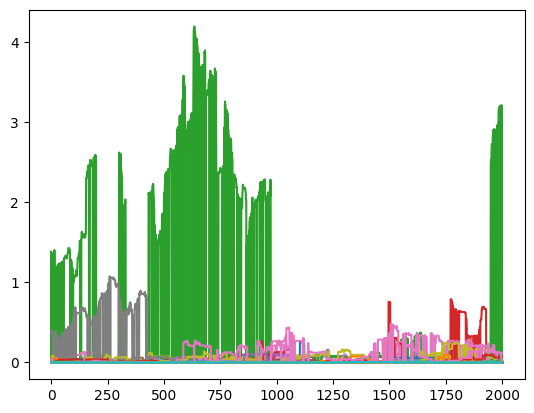

Threshold: 0

Genes per Fold: 
1: 3
4: 18
6: 98
9: 33
10: 331
11: 49
Total Number of Matches: 532
Total Matches with >= 1 Non-Zero Value: 108
Percentage of TSSs with No Signal: 79.70%
TSSs w/ Signal: [('ENSG00000133105', 6), ('ENSG00000236013', 6), ('ENSG00000133121', 6), ('ENSG00000112183_3', 6), ('ENSG00000146147_3', 6), ('ENSG00000139737_1', 6), ('ENSG00000259237', 9), ('ENSG00000139220', 9), ('ENSG00000165966_2', 9), ('ENSG00000286279', 9), ('ENSG00000067715_2', 9), ('ENSG00000104043', 9), ('ENSG00000205592', 9), ('ENSG00000257894', 9), ('ENSG00000284848', 9), ('ENSG00000259188', 9), ('ENSG00000129422', 10), ('ENSG00000269289', 10), ('ENSG00000164741_2', 10), ('ENSG00000171051_1', 10), ('ENSG00000104938', 10), ('ENSG00000164808_1', 10), ('ENSG00000254006', 10), ('ENSG00000176797', 10), ('ENSG00000170323', 10), ('ENSG00000253796', 10), ('ENSG00000076554_1', 10), ('ENSG00000267777', 10), ('ENSG00000253230', 10), ('ENSG00000253877_1', 10), ('ENSG00000253642', 10), ('ENSG00000089327_2'

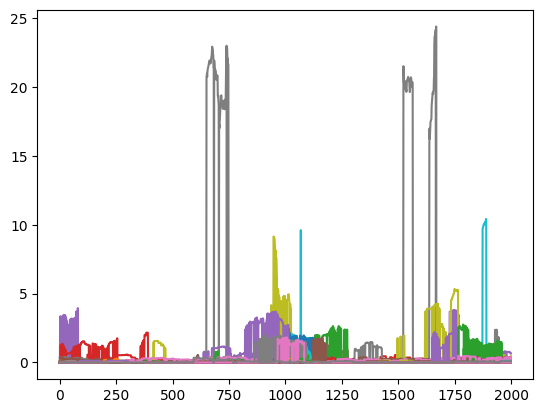

<Figure size 640x480 with 0 Axes>

In [55]:
test_thresholds(gm, gm_h5, "Pred", [0], "l")
test_thresholds(k5, k5_h5, "Pred", [0], "l")

Low Errors

In [56]:
gm["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.005350
0.05    0.027846
0.10    0.057697
Name: Error, dtype: float64

In [57]:
k5["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.005069
0.05    0.025330
0.10    0.051010
Name: Error, dtype: float64

GM12878: 
Threshold: 0.001

Genes per Fold: 
1: 8
2: 3
3: 6
4: 2
6: 5
7: 2
8: 3
10: 2
11: 1
12: 1
Total Number of Matches: 33
Total Matches with >= 1 Non-Zero Value: 15
Percentage of TSSs with No Signal: 54.55%
TSSs w/ Signal: [('ENSG00000272865', 1), ('ENSG00000134215', 1), ('ENSG00000142875_5', 1), ('ENSG00000172292', 2), ('ENSG00000177352', 3), ('ENSG00000157538', 3), ('ENSG00000118849', 3), ('ENSG00000163751_1', 3), ('ENSG00000171195', 4), ('ENSG00000136144', 6), ('ENSG00000280707', 6), ('ENSG00000261189', 6), ('ENSG00000135525_3', 6), ('ENSG00000104848', 10), ('ENSG00000130935', 12)]
TSSs w/o Signal: [('ENSG00000163221', 1), ('ENSG00000272865', 1), ('ENSG00000134215', 1), ('ENSG00000142875_5', 1), ('ENSG00000121310', 1), ('ENSG00000134200', 1), ('ENSG00000227868', 1), ('ENSG00000274020', 1), ('ENSG00000138964_3', 2), ('ENSG00000132323', 2), ('ENSG00000172292', 2), ('ENSG00000177352', 3), ('ENSG00000157538', 3), ('ENSG00000144962', 3), ('ENSG00000093183_2', 3), ('ENSG00000118849', 

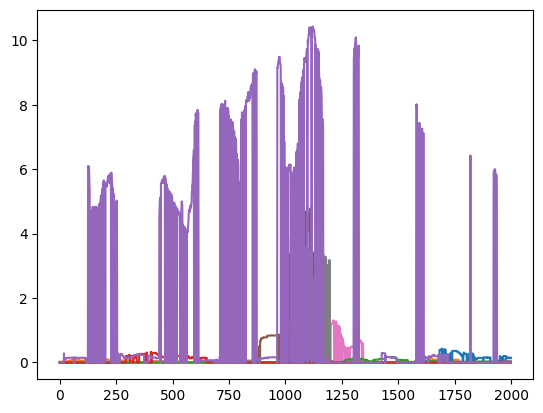

Threshold: 0.01

Genes per Fold: 
1: 116
2: 30
3: 42
4: 43
5: 16
6: 99
7: 25
8: 42
9: 25
10: 31
11: 24
12: 33
Total Number of Matches: 526
Total Matches with >= 1 Non-Zero Value: 244
Percentage of TSSs with No Signal: 53.61%
TSSs w/ Signal: [('ENSG00000188770', 1), ('ENSG00000152061_1', 1), ('ENSG00000243062', 1), ('ENSG00000162641_1', 1), ('ENSG00000227579', 1), ('ENSG00000228971', 1), ('ENSG00000116157', 1), ('ENSG00000236719_1', 1), ('ENSG00000162769', 1), ('ENSG00000232596', 1), ('ENSG00000134369_2', 1), ('ENSG00000230461', 1), ('ENSG00000260971', 1), ('ENSG00000143322', 1), ('ENSG00000143786', 1), ('ENSG00000116785', 1), ('ENSG00000187223', 1), ('ENSG00000116396_1', 1), ('ENSG00000169224_1', 1), ('ENSG00000162670_1', 1), ('ENSG00000142748', 1), ('ENSG00000240038', 1), ('ENSG00000244094', 1), ('ENSG00000219073', 1), ('ENSG00000134193', 1), ('ENSG00000143303', 1), ('ENSG00000007933', 1), ('ENSG00000116213', 1), ('ENSG00000143257', 1), ('ENSG00000271576', 1), ('ENSG00000116833', 1), 

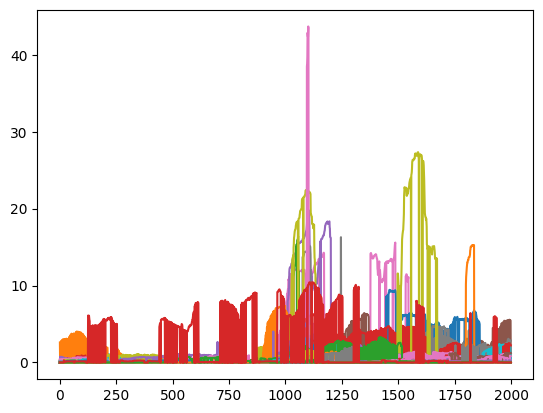

Threshold: 0.1

Genes per Fold: 
1: 679
2: 347
3: 393
4: 414
5: 402
6: 495
7: 402
8: 504
9: 460
10: 358
11: 279
12: 373
Total Number of Matches: 5106
Total Matches with >= 1 Non-Zero Value: 2503
Percentage of TSSs with No Signal: 50.98%
TSSs w/ Signal: [('ENSG00000189195_1', 1), ('ENSG00000287756', 1), ('ENSG00000152061_2', 1), ('ENSG00000188770', 1), ('ENSG00000133019_2', 1), ('ENSG00000228526_1', 1), ('ENSG00000132122', 1), ('ENSG00000163239', 1), ('ENSG00000234754', 1), ('ENSG00000233290_1', 1), ('ENSG00000152061_1', 1), ('ENSG00000271736', 1), ('ENSG00000168528', 1), ('ENSG00000203747_1', 1), ('ENSG00000135744_1', 1), ('ENSG00000131791', 1), ('ENSG00000228971_1', 1), ('ENSG00000287453', 1), ('ENSG00000116151_1', 1), ('ENSG00000134376', 1), ('ENSG00000178395', 1), ('ENSG00000159173_2', 1), ('ENSG00000121753_1', 1), ('ENSG00000271252', 1), ('ENSG00000132849_1', 1), ('ENSG00000230630_1', 1), ('ENSG00000142949_1', 1), ('ENSG00000182901', 1), ('ENSG00000243062', 1), ('ENSG00000130695', 

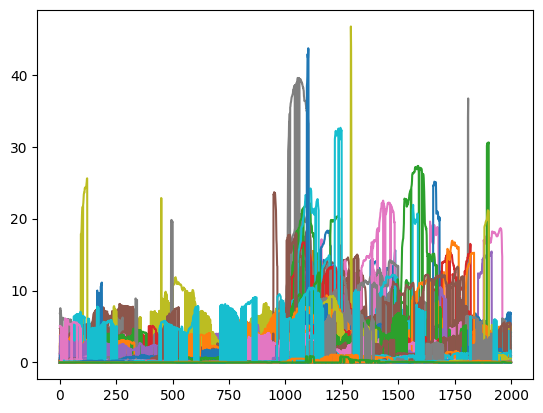

K562: 
Threshold: 0.001

Genes per Fold: 
1: 1
2: 1
3: 1
4: 14
5: 2
6: 10
7: 4
8: 1
9: 4
10: 13
11: 7
Total Number of Matches: 58
Total Matches with >= 1 Non-Zero Value: 25
Percentage of TSSs with No Signal: 56.90%
TSSs w/ Signal: [('ENSG00000064703_2', 1), ('ENSG00000145362_1', 4), ('ENSG00000168214_5', 4), ('ENSG00000265485_1', 4), ('ENSG00000082397_2', 4), ('ENSG00000260552', 4), ('ENSG00000171199', 4), ('ENSG00000171201', 4), ('ENSG00000168675_6', 4), ('ENSG00000283384', 6), ('ENSG00000136111_1', 6), ('ENSG00000073910_1', 6), ('ENSG00000102743', 6), ('ENSG00000100994', 7), ('ENSG00000125968', 7), ('ENSG00000177105_1', 8), ('ENSG00000048540_4', 9), ('ENSG00000257443', 9), ('ENSG00000065000', 10), ('ENSG00000031823', 10), ('ENSG00000079462', 10), ('ENSG00000227912', 11), ('ENSG00000224934', 11), ('ENSG00000237949', 11), ('ENSG00000223993', 11)]
TSSs w/o Signal: [('ENSG00000064703_2', 1), ('ENSG00000132031', 2), ('ENSG00000163885', 3), ('ENSG00000145362_1', 4), ('ENSG00000168214_5', 4

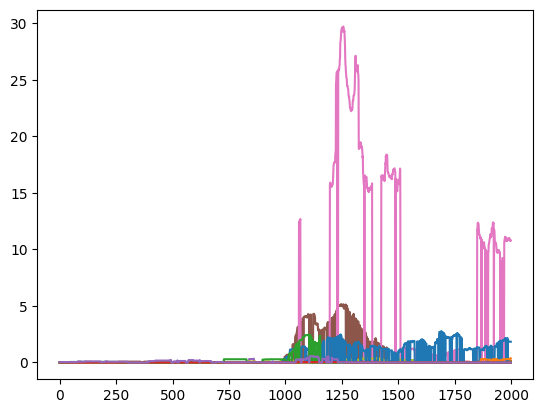

Threshold: 0.01

Genes per Fold: 
1: 27
2: 28
3: 19
4: 143
5: 25
6: 87
7: 26
8: 16
9: 49
10: 71
11: 50
12: 24
Total Number of Matches: 565
Total Matches with >= 1 Non-Zero Value: 216
Percentage of TSSs with No Signal: 61.77%
TSSs w/ Signal: [('ENSG00000174606_1', 1), ('ENSG00000271252', 1), ('ENSG00000082512_1', 1), ('ENSG00000120334_1', 1), ('ENSG00000175707', 1), ('ENSG00000117000', 1), ('ENSG00000187017_1', 1), ('ENSG00000064703_2', 1), ('ENSG00000143443', 1), ('ENSG00000224968', 1), ('ENSG00000142634', 1), ('ENSG00000285728', 1), ('ENSG00000116962', 1), ('ENSG00000070413', 2), ('ENSG00000226479', 2), ('ENSG00000128159', 2), ('ENSG00000184261', 2), ('ENSG00000144224', 2), ('ENSG00000099956', 2), ('ENSG00000144057_2', 2), ('ENSG00000168393', 2), ('ENSG00000242242_1', 3), ('ENSG00000244300', 3), ('ENSG00000168297', 3), ('ENSG00000206535', 3), ('ENSG00000144712', 3), ('ENSG00000160191', 3), ('ENSG00000142192_1', 3), ('ENSG00000114054', 3), ('ENSG00000164087', 3), ('ENSG00000163681', 3)

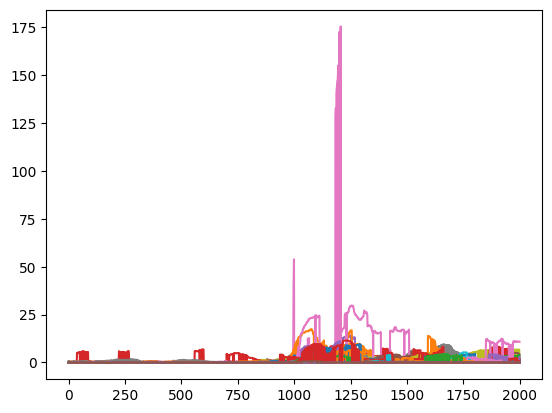

Threshold: 0.1

Genes per Fold: 
1: 553
2: 500
3: 373
4: 560
5: 193
6: 598
7: 230
8: 405
9: 645
10: 665
11: 550
12: 263
Total Number of Matches: 5535
Total Matches with >= 1 Non-Zero Value: 2322
Percentage of TSSs with No Signal: 58.05%
TSSs w/ Signal: [('ENSG00000116183', 1), ('ENSG00000223694', 1), ('ENSG00000117009_1', 1), ('ENSG00000135801', 1), ('ENSG00000236719_1', 1), ('ENSG00000142945', 1), ('ENSG00000181036', 1), ('ENSG00000291157', 1), ('ENSG00000084652', 1), ('ENSG00000198492_1', 1), ('ENSG00000151414', 1), ('ENSG00000143153_1', 1), ('ENSG00000143469', 1), ('ENSG00000160097', 1), ('ENSG00000244057', 1), ('ENSG00000223883', 1), ('ENSG00000272865', 1), ('ENSG00000291123', 1), ('ENSG00000143167', 1), ('ENSG00000143303', 1), ('ENSG00000158764', 1), ('ENSG00000197472', 1), ('ENSG00000162543', 1), ('ENSG00000197982', 1), ('ENSG00000143248_1', 1), ('ENSG00000092853', 1), ('ENSG00000188004', 1), ('ENSG00000227868', 1), ('ENSG00000181450', 1), ('ENSG00000143603_1', 1), ('ENSG00000162

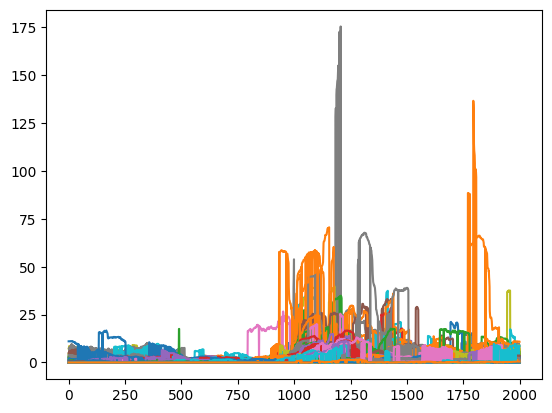

<Figure size 640x480 with 0 Axes>

In [58]:
print("GM12878: ")
test_thresholds(gm, gm_h5, "Error", [0.001, 0.01, 0.1], "l")

print("K562: ")
test_thresholds(k5, k5_h5, "Error", [0.001, 0.01, 0.1], "l")

High Errors

In [59]:
gm["Error"].quantile([0.9, 0.95, 0.99])

0.90    1.079988
0.95    1.487276
0.99    2.266954
Name: Error, dtype: float64

In [60]:
k5["Error"].quantile([0.9, 0.95, 0.99])

0.90    1.176917
0.95    1.627252
0.99    2.358835
Name: Error, dtype: float64

GM12878: 
Threshold: 1

Genes per Fold: 
1: 365
2: 283
3: 220
4: 160
5: 289
6: 284
7: 223
8: 358
9: 287
10: 338
11: 224
12: 278
Total Number of Matches: 3309
Total Matches with >= 1 Non-Zero Value: 2560
Percentage of TSSs with No Signal: 22.64%
TSSs w/ Signal: [('ENSG00000117543', 1), ('ENSG00000117395', 1), ('ENSG00000238287', 1), ('ENSG00000126698', 1), ('ENSG00000162385', 1), ('ENSG00000143603_1', 1), ('ENSG00000078369_1', 1), ('ENSG00000054282', 1), ('ENSG00000198744', 1), ('ENSG00000153187_3', 1), ('ENSG00000116221', 1), ('ENSG00000158481', 1), ('ENSG00000066557', 1), ('ENSG00000225556', 1), ('ENSG00000291137_1', 1), ('ENSG00000284693', 1), ('ENSG00000172380', 1), ('ENSG00000027869', 1), ('ENSG00000163191', 1), ('ENSG00000233514', 1), ('ENSG00000132881', 1), ('ENSG00000177628_1', 1), ('ENSG00000086015', 1), ('ENSG00000160818', 1), ('ENSG00000125462_2', 1), ('ENSG00000234741_1', 1), ('ENSG00000198468', 1), ('ENSG00000009790_1', 1), ('ENSG00000280670', 1), ('ENSG00000163565_2', 1), 

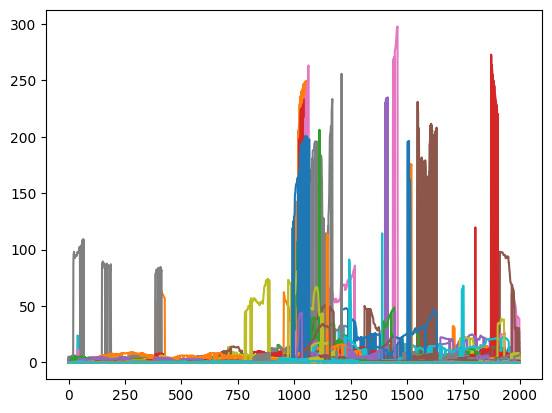

Threshold: 1.5

Genes per Fold: 
1: 178
2: 124
3: 88
4: 48
5: 122
6: 117
7: 97
8: 143
9: 117
10: 148
11: 113
12: 101
Total Number of Matches: 1396
Total Matches with >= 1 Non-Zero Value: 1152
Percentage of TSSs with No Signal: 17.48%
TSSs w/ Signal: [('ENSG00000117543', 1), ('ENSG00000156171', 1), ('ENSG00000126698', 1), ('ENSG00000143319', 1), ('ENSG00000198744', 1), ('ENSG00000284693', 1), ('ENSG00000233514', 1), ('ENSG00000077152', 1), ('ENSG00000132881', 1), ('ENSG00000177628_1', 1), ('ENSG00000160818', 1), ('ENSG00000198468', 1), ('ENSG00000158006', 1), ('ENSG00000280670', 1), ('ENSG00000163565_2', 1), ('ENSG00000143363', 1), ('ENSG00000116922', 1), ('ENSG00000143578_1', 1), ('ENSG00000117632_2', 1), ('ENSG00000177888', 1), ('ENSG00000125703', 1), ('ENSG00000160688', 1), ('ENSG00000163468_1', 1), ('ENSG00000176261', 1), ('ENSG00000126709', 1), ('ENSG00000143297', 1), ('ENSG00000117862', 1), ('ENSG00000155366', 1), ('ENSG00000179051_1', 1), ('ENSG00000143185', 1), ('ENSG00000184678

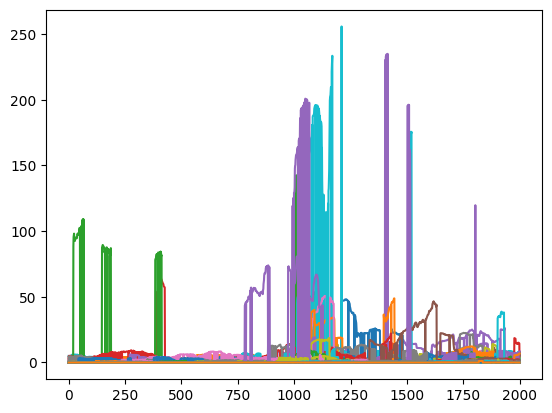

Threshold: 2

Genes per Fold: 
1: 61
2: 35
3: 37
4: 14
5: 56
6: 46
7: 44
8: 41
9: 59
10: 50
11: 57
12: 46
Total Number of Matches: 546
Total Matches with >= 1 Non-Zero Value: 474
Percentage of TSSs with No Signal: 13.19%
TSSs w/ Signal: [('ENSG00000117543', 1), ('ENSG00000162385', 1), ('ENSG00000054282', 1), ('ENSG00000291137_1', 1), ('ENSG00000233514', 1), ('ENSG00000077152', 1), ('ENSG00000132881', 1), ('ENSG00000086015', 1), ('ENSG00000177888', 1), ('ENSG00000125703', 1), ('ENSG00000117862', 1), ('ENSG00000155366', 1), ('ENSG00000179051_1', 1), ('ENSG00000143185', 1), ('ENSG00000143621', 1), ('ENSG00000230937', 1), ('ENSG00000097033', 1), ('ENSG00000199377', 1), ('ENSG00000201317', 1), ('ENSG00000132704', 1), ('ENSG00000198793', 1), ('ENSG00000196154', 1), ('ENSG00000142669', 1), ('ENSG00000142583', 1), ('ENSG00000137955_1', 1), ('ENSG00000116793_1', 1), ('ENSG00000116691', 1), ('ENSG00000079277', 1), ('ENSG00000081692', 1), ('ENSG00000117419_1', 1), ('ENSG00000215835', 1), ('ENSG00

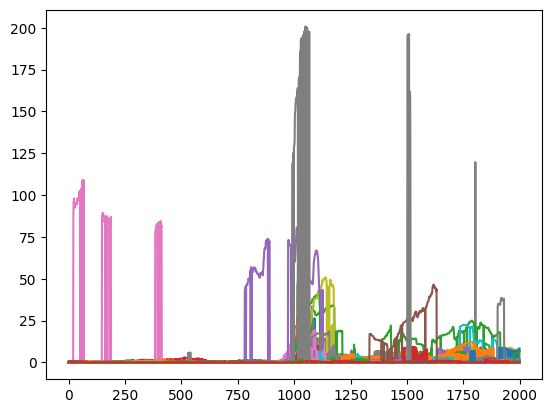

K562: 
Threshold: 1

Genes per Fold: 
1: 358
2: 344
3: 267
4: 179
5: 296
6: 267
7: 239
8: 352
9: 402
10: 447
11: 302
12: 373
Total Number of Matches: 3826
Total Matches with >= 1 Non-Zero Value: 2689
Percentage of TSSs with No Signal: 29.72%
TSSs w/ Signal: [('ENSG00000203667', 1), ('ENSG00000273338', 1), ('ENSG00000135845', 1), ('ENSG00000181754', 1), ('ENSG00000158773', 1), ('ENSG00000278274', 1), ('ENSG00000229344', 1), ('ENSG00000116459_1', 1), ('ENSG00000084073', 1), ('ENSG00000186063_1', 1), ('ENSG00000127603_1', 1), ('ENSG00000160785', 1), ('ENSG00000232480', 1), ('ENSG00000162601', 1), ('ENSG00000169905', 1), ('ENSG00000291158_1', 1), ('ENSG00000126698', 1), ('ENSG00000157870', 1), ('ENSG00000116560', 1), ('ENSG00000074800_1', 1), ('ENSG00000123473', 1), ('ENSG00000117862', 1), ('ENSG00000162433_1', 1), ('ENSG00000163156', 1), ('ENSG00000173409', 1), ('ENSG00000081870', 1), ('ENSG00000143314', 1), ('ENSG00000184260', 1), ('ENSG00000187147', 1), ('ENSG00000183520', 1), ('ENSG000

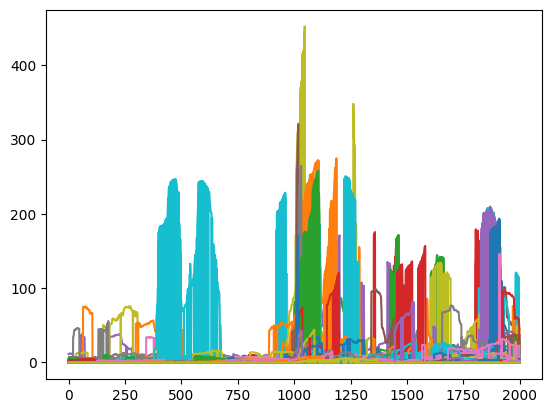

Threshold: 1.5

Genes per Fold: 
1: 187
2: 178
3: 145
4: 64
5: 144
6: 139
7: 128
8: 152
9: 160
10: 174
11: 113
12: 155
Total Number of Matches: 1739
Total Matches with >= 1 Non-Zero Value: 1360
Percentage of TSSs with No Signal: 21.79%
TSSs w/ Signal: [('ENSG00000203667', 1), ('ENSG00000173110', 1), ('ENSG00000135845', 1), ('ENSG00000158773', 1), ('ENSG00000116459_1', 1), ('ENSG00000127603_1', 1), ('ENSG00000163191', 1), ('ENSG00000126698', 1), ('ENSG00000157870', 1), ('ENSG00000130772', 1), ('ENSG00000117862', 1), ('ENSG00000173409', 1), ('ENSG00000081870', 1), ('ENSG00000143314', 1), ('ENSG00000237491', 1), ('ENSG00000137955', 1), ('ENSG00000163467', 1), ('ENSG00000187801', 1), ('ENSG00000004455', 1), ('ENSG00000202408', 1), ('ENSG00000184678', 1), ('ENSG00000153187_2', 1), ('ENSG00000142920', 1), ('ENSG00000229953', 1), ('ENSG00000135747', 1), ('ENSG00000162772', 1), ('ENSG00000137944', 1), ('ENSG00000177954', 1), ('ENSG00000122218', 1), ('ENSG00000223382', 1), ('ENSG00000198793', 1

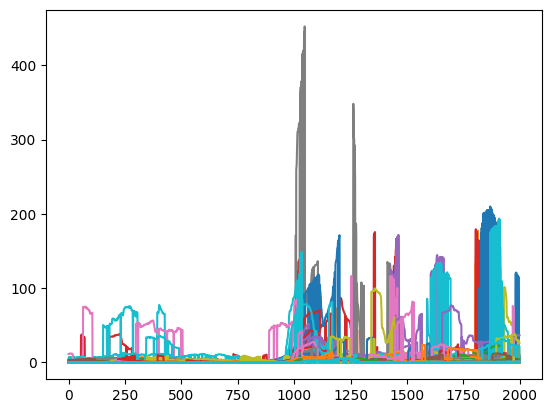

Threshold: 2

Genes per Fold: 
1: 99
2: 75
3: 81
4: 23
5: 59
6: 59
7: 70
8: 64
9: 49
10: 71
11: 47
12: 55
Total Number of Matches: 752
Total Matches with >= 1 Non-Zero Value: 628
Percentage of TSSs with No Signal: 16.49%
TSSs w/ Signal: [('ENSG00000203667', 1), ('ENSG00000158773', 1), ('ENSG00000116459_1', 1), ('ENSG00000162601', 1), ('ENSG00000163191', 1), ('ENSG00000157870', 1), ('ENSG00000130772', 1), ('ENSG00000117862', 1), ('ENSG00000143314', 1), ('ENSG00000237491', 1), ('ENSG00000162910', 1), ('ENSG00000163467', 1), ('ENSG00000004455', 1), ('ENSG00000184678', 1), ('ENSG00000229953', 1), ('ENSG00000135747', 1), ('ENSG00000162772', 1), ('ENSG00000177954', 1), ('ENSG00000223382', 1), ('ENSG00000198793', 1), ('ENSG00000186501', 1), ('ENSG00000031698', 1), ('ENSG00000157191', 1), ('ENSG00000143476', 1), ('ENSG00000143106', 1), ('ENSG00000135823', 1), ('ENSG00000160072', 1), ('ENSG00000086015', 1), ('ENSG00000116353', 1), ('ENSG00000116260', 1), ('ENSG00000117153', 1), ('ENSG0000011619

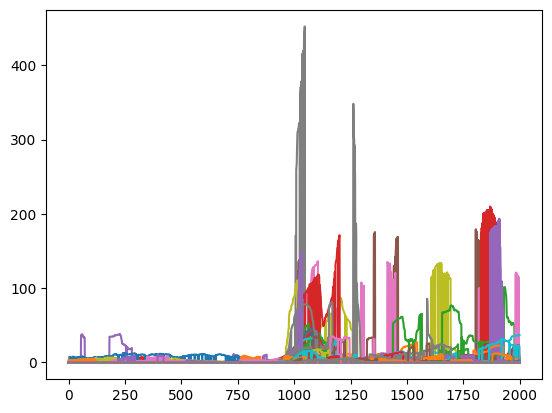

<Figure size 640x480 with 0 Axes>

In [61]:
print("GM12878: ")
test_thresholds(gm, gm_h5, "Error", [1, 1.5, 2], "g")

print("K562: ")
test_thresholds(k5, k5_h5, "Error", [1, 1.5, 2], "g")

Overestimates

GM12878: 
Threshold: 0

Genes per Fold: 
1: 1484
2: 1219
3: 763
4: 613
5: 1070
6: 1224
7: 1030
8: 1524
9: 1066
10: 1433
11: 681
12: 1085
Total Number of Matches: 13192
Total Matches with >= 1 Non-Zero Value: 8456
Percentage of TSSs with No Signal: 35.90%
TSSs w/ Signal: [('ENSG00000189195_1', 1), ('ENSG00000171163', 1), ('ENSG00000123473', 1), ('ENSG00000117395', 1), ('ENSG00000143498', 1), ('ENSG00000118194_3', 1), ('ENSG00000158869', 1), ('ENSG00000227733_1', 1), ('ENSG00000156171', 1), ('ENSG00000243364', 1), ('ENSG00000132122', 1), ('ENSG00000130939', 1), ('ENSG00000238107', 1), ('ENSG00000143603_1', 1), ('ENSG00000142599_2', 1), ('ENSG00000116871', 1), ('ENSG00000184270', 1), ('ENSG00000284188', 1), ('ENSG00000078369_1', 1), ('ENSG00000121904', 1), ('ENSG00000143319', 1), ('ENSG00000174021', 1), ('ENSG00000168159', 1), ('ENSG00000085831', 1), ('ENSG00000162736_1', 1), ('ENSG00000196187', 1), ('ENSG00000230623', 1), ('ENSG00000187583', 1), ('ENSG00000168765', 1), ('ENSG00000116747_

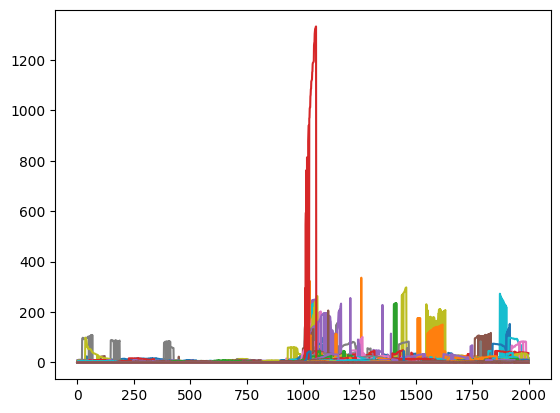

K562
Threshold: 0

Genes per Fold: 
1: 916
2: 903
3: 439
4: 676
5: 720
6: 901
7: 809
8: 1154
9: 1258
10: 1526
11: 1132
12: 1279
Total Number of Matches: 11713
Total Matches with >= 1 Non-Zero Value: 6966
Percentage of TSSs with No Signal: 40.53%
TSSs w/ Signal: [('ENSG00000143344_1', 1), ('ENSG00000041988', 1), ('ENSG00000116183', 1), ('ENSG00000203667', 1), ('ENSG00000131238', 1), ('ENSG00000142945', 1), ('ENSG00000273338', 1), ('ENSG00000133069', 1), ('ENSG00000142937', 1), ('ENSG00000121775', 1), ('ENSG00000278274', 1), ('ENSG00000229344', 1), ('ENSG00000116459_1', 1), ('ENSG00000084652', 1), ('ENSG00000160691_2', 1), ('ENSG00000226891', 1), ('ENSG00000116161_1', 1), ('ENSG00000143442_1', 1), ('ENSG00000160097', 1), ('ENSG00000273002', 1), ('ENSG00000117597', 1), ('ENSG00000117616_1', 1), ('ENSG00000081692', 1), ('ENSG00000204160_1', 1), ('ENSG00000040487', 1), ('ENSG00000117308_1', 1), ('ENSG00000291158_1', 1), ('ENSG00000237976', 1), ('ENSG00000162736', 1), ('ENSG00000079335_2', 1

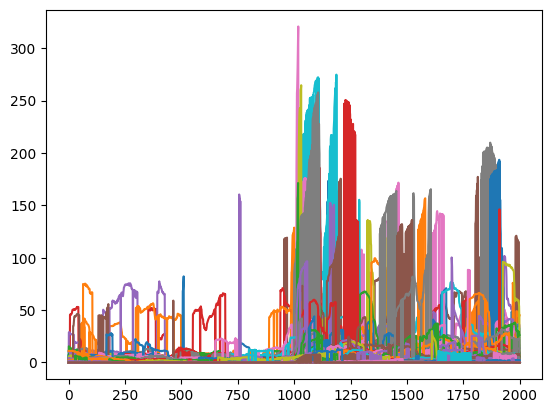

<Figure size 640x480 with 0 Axes>

In [62]:
print("GM12878: ")
test_thresholds(gm, gm_h5, "Signed Error", [0], "l")

print("K562")
test_thresholds(k5, k5_h5, "Signed Error", [0], "l")

Underestimates

GM12878: 
Threshold: 0

Genes per Fold: 
1: 1302
2: 1374
3: 1174
4: 976
5: 1253
6: 765
7: 1059
8: 1078
9: 1432
10: 1559
11: 1578
12: 1615
Total Number of Matches: 15165
Total Matches with >= 1 Non-Zero Value: 8684
Percentage of TSSs with No Signal: 42.74%
TSSs w/ Signal: [('ENSG00000117222', 1), ('ENSG00000117543', 1), ('ENSG00000287756', 1), ('ENSG00000238287', 1), ('ENSG00000117385', 1), ('ENSG00000228526_1', 1), ('ENSG00000076258', 1), ('ENSG00000126698', 1), ('ENSG00000163239', 1), ('ENSG00000234754', 1), ('ENSG00000233290_1', 1), ('ENSG00000152061_1', 1), ('ENSG00000162385', 1), ('ENSG00000162692', 1), ('ENSG00000271736', 1), ('ENSG00000228794_2', 1), ('ENSG00000164008', 1), ('ENSG00000117016', 1), ('ENSG00000171793_1', 1), ('ENSG00000142686', 1), ('ENSG00000236719', 1), ('ENSG00000122417_1', 1), ('ENSG00000054282', 1), ('ENSG00000116329', 1), ('ENSG00000168528', 1), ('ENSG00000203747_1', 1), ('ENSG00000163374_1', 1), ('ENSG00000186364', 1), ('ENSG00000228971_1', 1), ('ENSG0000014

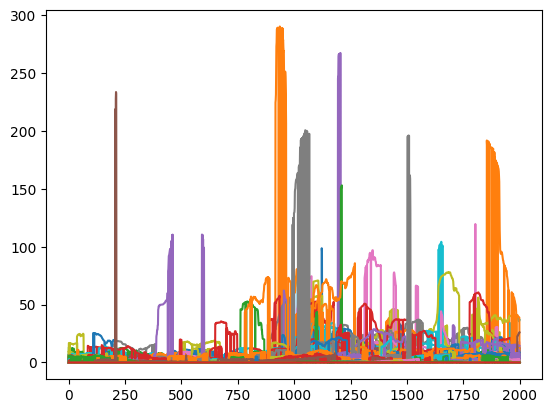

K562
Threshold: 0

Genes per Fold: 
1: 1870
2: 1690
3: 1498
4: 913
5: 1603
6: 1088
7: 1280
8: 1448
9: 1240
10: 1466
11: 1127
12: 1421
Total Number of Matches: 16644
Total Matches with >= 1 Non-Zero Value: 8454
Percentage of TSSs with No Signal: 49.21%
TSSs w/ Signal: [('ENSG00000162711', 1), ('ENSG00000289881', 1), ('ENSG00000133063', 1), ('ENSG00000223694', 1), ('ENSG00000219481', 1), ('ENSG00000135801', 1), ('ENSG00000163395', 1), ('ENSG00000162891', 1), ('ENSG00000196418_1', 1), ('ENSG00000231365', 1), ('ENSG00000236719_1', 1), ('ENSG00000085552', 1), ('ENSG00000134222', 1), ('ENSG00000142621', 1), ('ENSG00000132781_1', 1), ('ENSG00000137948', 1), ('ENSG00000181036', 1), ('ENSG00000186056', 1), ('ENSG00000173110', 1), ('ENSG00000162763', 1), ('ENSG00000162654', 1), ('ENSG00000291157', 1), ('ENSG00000135845', 1), ('ENSG00000181754', 1), ('ENSG00000143862', 1), ('ENSG00000233791_1', 1), ('ENSG00000158869', 1), ('ENSG00000290842', 1), ('ENSG00000135749', 1), ('ENSG00000117676_1', 1), (

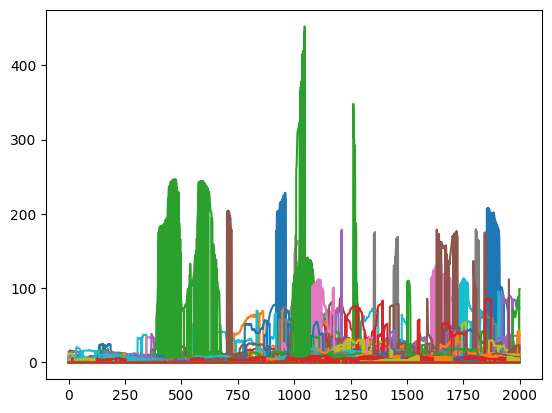

<Figure size 640x480 with 0 Axes>

In [63]:
print("GM12878: ")
test_thresholds(gm, gm_h5, "Signed Error", [0], "g")

print("K562")
test_thresholds(k5, k5_h5, "Signed Error", [0], "g")

Zero Signal

GM12878: 
Threshold: 0

Genes per Fold: 
1: 981
2: 822
3: 710
4: 617
5: 783
6: 649
7: 652
8: 815
9: 805
10: 909
11: 618
12: 719
Total Number of Matches: 9080
Total Matches with >= 1 Non-Zero Value: 4136
Percentage of TSSs with No Signal: 54.45%
TSSs w/ Signal: [('ENSG00000189195_1', 1), ('ENSG00000117543', 1), ('ENSG00000152061_2', 1), ('ENSG00000188770', 1), ('ENSG00000117215', 1), ('ENSG00000228526_1', 1), ('ENSG00000143507', 1), ('ENSG00000076258', 1), ('ENSG00000126698', 1), ('ENSG00000132122', 1), ('ENSG00000233290_1', 1), ('ENSG00000152061_1', 1), ('ENSG00000162385', 1), ('ENSG00000168528', 1), ('ENSG00000198691_1', 1), ('ENSG00000173614', 1), ('ENSG00000135744_1', 1), ('ENSG00000158887', 1), ('ENSG00000224259', 1), ('ENSG00000159173_2', 1), ('ENSG00000271252', 1), ('ENSG00000132849_1', 1), ('ENSG00000230630_1', 1), ('ENSG00000196189_2', 1), ('ENSG00000142632_2', 1), ('ENSG00000142615', 1), ('ENSG00000158485', 1), ('ENSG00000291137_1', 1), ('ENSG00000132681_1', 1), ('ENSG00000284

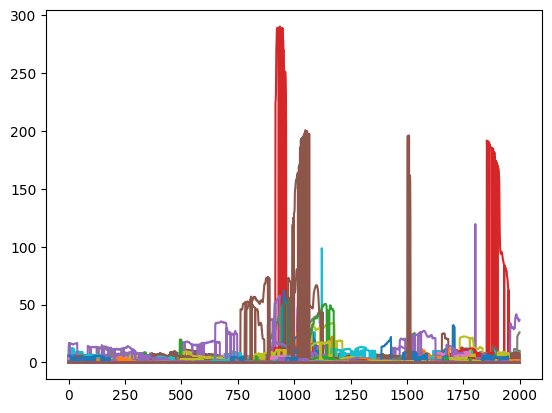

K562: 
Threshold: 0

Genes per Fold: 
1: 1253
2: 1155
3: 928
4: 772
5: 1085
6: 846
7: 862
8: 1108
9: 1116
10: 1237
11: 843
12: 1040
Total Number of Matches: 12245
Total Matches with >= 1 Non-Zero Value: 5189
Percentage of TSSs with No Signal: 57.62%
TSSs w/ Signal: [('ENSG00000162711', 1), ('ENSG00000116183', 1), ('ENSG00000133063', 1), ('ENSG00000282881', 1), ('ENSG00000223694', 1), ('ENSG00000162891', 1), ('ENSG00000236719_1', 1), ('ENSG00000142621', 1), ('ENSG00000137948', 1), ('ENSG00000181036', 1), ('ENSG00000173110', 1), ('ENSG00000162654', 1), ('ENSG00000291157', 1), ('ENSG00000135845', 1), ('ENSG00000181754', 1), ('ENSG00000158869', 1), ('ENSG00000143125', 1), ('ENSG00000162739', 1), ('ENSG00000116748', 1), ('ENSG00000127124_1', 1), ('ENSG00000173614', 1), ('ENSG00000118194_2', 1), ('ENSG00000171680', 1), ('ENSG00000224174', 1), ('ENSG00000016602', 1), ('ENSG00000232480', 1), ('ENSG00000244057', 1), ('ENSG00000135744_1', 1), ('ENSG00000223883', 1), ('ENSG00000142583_2', 1), ('E

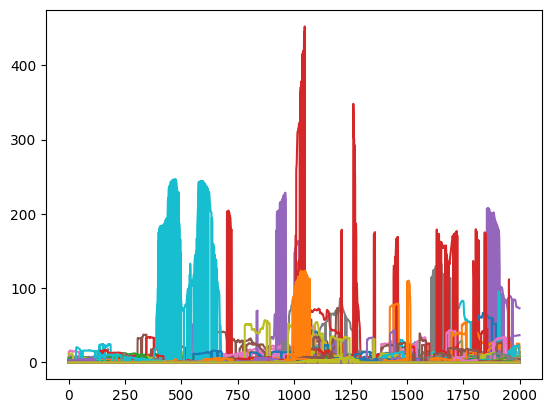

<Figure size 640x480 with 0 Axes>

In [64]:
print("GM12878: ")
test_thresholds(gm, gm_h5, "actual", [0], "eq")

print("K562: ")
test_thresholds(k5, k5_h5, "actual", [0], "eq")